## Description:

This script produces Figure S7, Figure S8.

Input:   'data/AR_features/part2/%s.AR_events_feature.1981-2015.nc' % (method)

Output:   'data/AR_classification/AR_3class.%s.nc' % (method)

In [1]:
import numpy as np
import netCDF4 as nc
import datetime as dt
import pandas as pd

from sklearn.cluster import KMeans
#import mpl_toolkits.mplot3d as mpl3d
import scipy

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

In [2]:
rootdir = '/raid1/chen423/serdp/archive/GRL2018/'

In [3]:
def get_nc_data(infile, var):
    tmpgroup = nc.Dataset(infile, 'r', format='NETCDF4')
    outdata = tmpgroup.variables[var][:]
    tmpgroup.close()
    return outdata

### classification functions

In [4]:
def normalize_input_various_method(indata, method):
    # only handles 1-d array
    
    if method=='meanstd':
        outdata = (indata-np.mean(indata))/np.std(indata)
    
    if method=='uniform':
        outdata = (indata-np.min(indata))/(np.max(indata)-np.min(indata))
    
    if method=='cdf':
        outdata = np.ones(indata.shape)*9999
        for i in np.arange(indata.shape[0]):
            outdata[i] = ((indata<=indata[i]).sum())/indata.shape[0]
        
    return outdata

In [5]:
dic_feature_id = {'area (whole)':0, 'area (land)':1, 'intensity (whole)':2, 'intensity (land)':3, 'coastal width':4,
                  'coastal intensity':5, 'start time':6, 'duration':7, 'center time':8, 'center lat':9, 'center lon':10}

In [6]:
def AR_classification(nclass, ARfeature_full, indic):
    nfeatures = len(indic.keys())
    ARfeature_norm = np.zeros((ARfeature_full.shape[0], nfeatures))
    for f in np.arange(nfeatures):
        tmp_feature = list(indic.keys())[f]
        #print(tmp_feature, dic_feature_id[tmp_feature], indic[tmp_feature])
        ARfeature_norm[:,f] = normalize_input_various_method(ARfeature_full[:,dic_feature_id[tmp_feature]], indic[tmp_feature])

    kmean_model = KMeans(n_clusters=nclass, random_state=0)
    kmean_results = kmean_model.fit(ARfeature_norm)

    return kmean_results.labels_, ARfeature_norm, list(indic.keys()), kmean_model

In [7]:
def consistent_AR_class_order(indata, order):
    # use: to make the AR class index consistent between different datasets.
    outdata = np.ones(indata.shape, dtype=np.int32)*9999
    outdata[indata==0] = 9990
    outdata[indata==1] = 9991
    outdata[indata==2] = 9992
    for i in np.arange(3):
        outdata[outdata==(9990+order[i])] = int(i)
    return outdata

### plots

In [8]:
def visualize_feature_hist_1plot(nclasses, kmean_result, feature, feature_names, nstd, ymaxs):

    colors = ['royalblue', 'lightseagreen', 'orange', 'fuchsia']
    xmins = [-1*nstd,-1*nstd]
    xmaxs = [nstd, nstd]
    bins = np.arange(-1*nstd,nstd+0.1,0.25)
    bincenter = bins[0:(bins.shape[0]-1)]-0.125
    
    fig_handle = plt.figure(figsize=(3.5*len(feature_names),9))

    count = 1
    for y in np.arange(len(feature_names)):
        xmin = xmins[y]
        xmax = xmaxs[y]
        ymin = 0
        ymax = ymaxs[y]
        ax = fig_handle.add_subplot(nclasses,len(feature_names),count)
        #ax = plt.subplot2grid()
        for x in np.arange(nclasses):          
            plot_data, binedges = np.histogram(feature[:,y][np.where(kmean_result==x)], bins=bins)
            ax.plot(bincenter, plot_data, color=colors[x], linewidth=2)
        ax.plot((0,0), (0,6000), '--', color='black')
        ax.plot((1,1), (0,6000), '-', color='gray', linewidth=1, alpha=0.6)
        ax.plot((-1,-1), (0,6000), '-', color='gray', linewidth=1, alpha=0.6)
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])
        ax.xaxis.set_tick_params(labelsize=10)
        ax.set_xlabel('Normalized '+feature_names[y], size=12)
        ax.yaxis.set_tick_params(labelsize=10)
        if y==0:
            ax.set_ylabel('# of events', size=12)
        count = count + 1

    plt.tight_layout()
    
    return fig_handle

## main functions

In [9]:
def derive_classified_AR(method):
    infile = rootdir+'data/AR_features/part2/%s.AR_events_feature.1981-2015.nc' % (method)
    ARfeature_full = get_nc_data(infile, 'AR_event_feature')

    AR_class_index_raw, ARfeature_norm, ARfeature_names, clf = AR_classification(3, ARfeature_full, {'duration':'meanstd', 'intensity (land)':'meanstd'})
    AR_class_index = consistent_AR_class_order(AR_class_index_raw, conversion_orders[method])
    
    return AR_class_index, ARfeature_full, ARfeature_norm, ARfeature_names, clf

In [10]:
# GRL paper data version
#conversion_orders = {'rutz':[0,2,1], 'gershunov':[0,1,2], 'guan':[1,0,2],
#                     'goldenson':[2,1,0], 'pnnl1':[0,2,1], 'pnnl2':[0,1,2],
#                     'lora':[1,2,0], 'payne':[0,1,2], 'tempest':[0,1,2], 'walton':[0,1,2]}

# updated version
conversion_orders = {'rutz':[0,1,2], 'gershunov':[1,2,0], 'guan':[1,2,0],
                     'goldenson':[0,1,2], 'pnnl1':[0,1,2], 'pnnl2':[1,2,0],
                     'lora':[0,2,1], 'payne':[0,2,1], 'tempest':[1,2,0], 'walton':[1,0,2]}

AR_class_name = ['weak','flash','prolong']

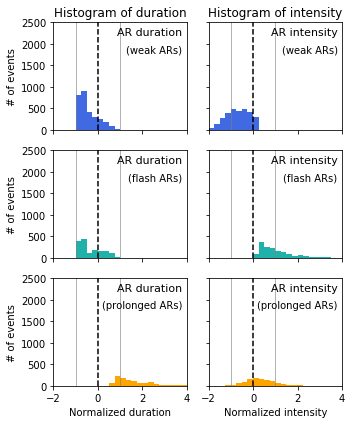

In [11]:
method = 'gershunov'

kmean_result, _, feature, feature_names, clf = derive_classified_AR(method)

nclasses=3
nstd = 4
ymaxs = [2500,2500,2500]
#ymaxs = [500,500,500]

colors = ['royalblue', 'lightseagreen', 'orange', 'fuchsia']
    
xmins = [-2,-2]
xmaxs = [4, 4]
bins = np.arange(-1*nstd,nstd+0.1,0.25)
ymins = [0,0,0,0]

fig1 = plt.figure(figsize=(5,6))

ax1 = plt.subplot(3,2,1)
ax2 = plt.subplot(3,2,2)
ax3 = plt.subplot(3,2,3)
ax4 = plt.subplot(3,2,4)
ax5 = plt.subplot(3,2,5)
ax6 = plt.subplot(3,2,6)

# weak
ax1.hist(feature[:,0][np.where(kmean_result==0)], bins, color=colors[0])
ax1.plot((0,0), (0,6000), '--', color='black')
ax1.plot((1,1), (0,6000), '-', color='gray', linewidth=1, alpha=0.6)
ax1.plot((-1,-1), (0,6000), '-', color='gray', linewidth=1, alpha=0.6)
ax1.set_xlim([xmins[0], xmaxs[0]])
ax1.set_ylim([ymins[0], ymaxs[0]])

ax2.hist(feature[:,1][np.where(kmean_result==0)], bins, color=colors[0])
ax2.plot((0,0), (0,6000), '--', color='black')
ax2.plot((1,1), (0,6000), '-', color='gray', linewidth=1, alpha=0.6)
ax2.plot((-1,-1), (0,6000), '-', color='gray', linewidth=1, alpha=0.6)
ax2.set_xlim([xmins[1], xmaxs[1]])
ax2.set_ylim([ymins[1], ymaxs[1]])


# flash
ax3.hist(feature[:,0][np.where(kmean_result==1)], bins, color=colors[1])
ax3.plot((0,0), (0,6000), '--', color='black')
ax3.plot((1,1), (0,6000), '-', color='gray', linewidth=1, alpha=0.6)
ax3.plot((-1,-1), (0,6000), '-', color='gray', linewidth=1, alpha=0.6)
ax3.set_xlim([xmins[0], xmaxs[0]])
ax3.set_ylim([ymins[0], ymaxs[0]])

ax4.hist(feature[:,1][np.where(kmean_result==1)], bins, color=colors[1])
ax4.plot((0,0), (0,6000), '--', color='black')
ax4.plot((1,1), (0,6000), '-', color='gray', linewidth=1, alpha=0.6)
ax4.plot((-1,-1), (0,6000), '-', color='gray', linewidth=1, alpha=0.6)
ax4.set_xlim([xmins[1], xmaxs[1]])
ax4.set_ylim([ymins[1], ymaxs[1]])


# prolonged
ax5.hist(feature[:,0][np.where(kmean_result==2)], bins, color=colors[2])
ax5.plot((0,0), (0,6000), '--', color='black')
ax5.plot((1,1), (0,6000), '-', color='gray', linewidth=1, alpha=0.6)
ax5.plot((-1,-1), (0,6000), '-', color='gray', linewidth=1, alpha=0.6)
ax5.set_xlim([xmins[0], xmaxs[0]])
ax5.set_ylim([ymins[0], ymaxs[0]])

ax6.hist(feature[:,1][np.where(kmean_result==2)], bins, color=colors[2])
ax6.plot((0,0), (0,6000), '--', color='black')
ax6.plot((1,1), (0,6000), '-', color='gray', linewidth=1, alpha=0.6)
ax6.plot((-1,-1), (0,6000), '-', color='gray', linewidth=1, alpha=0.6)
ax6.set_xlim([xmins[1], xmaxs[1]])
ax6.set_ylim([ymins[1], ymaxs[1]])


for axis in [ax1,ax2,ax3,ax4]:
    axis.set_xticklabels([])
ax5.xaxis.set_tick_params(labelsize=10)
ax6.xaxis.set_tick_params(labelsize=10)
ax5.set_xlabel('Normalized duration', size=10)
ax6.set_xlabel('Normalized intensity', size=10)

for axis in [ax1,ax3,ax5]:
    axis.yaxis.set_tick_params(labelsize=10)
    axis.set_ylabel('# of events', size=10)

for axis in [ax2,ax4,ax6]:
    axis.set_yticklabels([])
    
ax1.set_title('Histogram of duration', size=12)
ax2.set_title('Histogram of intensity', size=12)

for axis in [ax1,ax2]:
    axis.text(3.8, 1800, '(weak ARs)', ha='right', size=10)
for axis in [ax3,ax4]:
    axis.text(3.8, 1800, '(flash ARs)', ha='right', size=10)
for axis in [ax5,ax6]:
    axis.text(3.8, 1800, '(prolonged ARs)', ha='right', size=10)
    
for axis in [ax1,ax3,ax5]:
    axis.text(3.8, 2200, 'AR duration', ha='right', size=11)
for axis in [ax2,ax4,ax6]:
    axis.text(3.8, 2200, 'AR intensity', ha='right', size=11)
    
plt.tight_layout()
plt.show()
#fig1.savefig(rootdir+'plots/figS7.%s.png' % (method), dpi=300)
fig1.clf()
del(fig1)

In [12]:
x_vec = np.arange(-2,11,0.1)
y_vec = np.arange(-4,5,0.1)
xx, yy = np.meshgrid(x_vec, y_vec)
Z_ensemble = np.zeros((6, xx.shape[0], xx.shape[1]))
xx_1less, yy_1less = np.meshgrid(x_vec[0:(x_vec.shape[0]-1)], y_vec[0:(y_vec.shape[0]-1)])
H_ensemble = np.zeros((6, xx_1less.shape[0], xx_1less.shape[1]))

method_list = ['rutz', 'gershunov', 'guan', 'goldenson', 'pnnl1', 'pnnl2']

for i in np.arange(6):
    AR_class_index, ARfeature_full, ARfeature_norm, ARfeature_names, clf = derive_classified_AR(method_list[i])
    Z_raw = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = consistent_AR_class_order(Z_raw, conversion_orders[method_list[i]])
    Z_ensemble[i,:] = Z.reshape(xx.shape)
    H_raw, xedges, yedges = np.histogram2d(ARfeature_norm[:,0], ARfeature_norm[:,1], bins=(x_vec, y_vec))
    H_raw = H_raw.T
    H_ensemble[i][H_raw>0] = np.log(H_raw[H_raw>0])+1
    
    
Z_concept_tmp, tmp = scipy.stats.mode(Z_ensemble, axis=0)
Z_concept = Z_concept_tmp[0]

H_ensemble[H_ensemble==0] = np.nan

In [13]:
def plot_panel_ens_bound(axes):
    x_vec = np.arange(-2,11,0.1)
    y_vec = np.arange(-4,5,0.1)
    xx, yy = np.meshgrid(x_vec, y_vec)
    axes.pcolormesh(xx, yy, Z_concept, cmap=cmap3, alpha=0.8, shading='gouraud', rasterized=True)
    
    axes.set_xlabel('normalized duration', size=13)
    axes.set_ylabel('normalized intenisty', size=13)
    axes.set_xlim([-2,10])
    axes.set_ylim([-4,4])
    axes.set_title('Ensemble Decision Boundary', size=12)
    
def plot_panel_ind_bound(axes, index, method2):
    
    x_vec = np.arange(-2,11,0.1)
    y_vec = np.arange(-4,5,0.1)
    xx, yy = np.meshgrid(x_vec, y_vec)
    xx_1less, yy_1less = np.meshgrid(x_vec[0:(x_vec.shape[0]-1)], y_vec[0:(y_vec.shape[0]-1)])
    
    axes.pcolormesh(xx, yy, Z_ensemble[index], cmap=cmap3, alpha=1, shading='gouraud', rasterized=True)
    axes.pcolormesh(xx_1less, yy_1less, H_ensemble[index], cmap='Blues', vmin=0, vmax=5)
    axes.set_xlim([-2,10])
    axes.set_ylim([-4,4])
    axes.set_title(method2, size=12)

In [14]:
def plot_panel_decision_bound(axes, method, method2):
    
    AR_class_index, ARfeature_full, ARfeature_norm, ARfeature_names, clf = derive_classified_AR(method)
    
    #x_vec = np.arange(int(ARfeature_norm[:,0].min()-2), int(ARfeature_norm[:,0].max()+2), 0.1)
    #y_vec = np.arange(int(ARfeature_norm[:,1].min()-2), int(ARfeature_norm[:,1].max()+2), 0.1)
    x_vec = np.arange(-2,10,0.1)
    y_vec = np.arange(-4,4,0.1)
    xx, yy = np.meshgrid(x_vec, y_vec)
    Z_raw = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = consistent_AR_class_order(Z_raw, conversion_orders[method])
    Z = Z.reshape(xx.shape)
    axes.pcolormesh(xx, yy, Z, cmap=cmap3, alpha=0.8, shading='gouraud', rasterized=True)
    #for i in np.arange(AR_class_index.shape[0]):
    #    axes.scatter(ARfeature_norm[i,0], ARfeature_norm[i,1], marker='o', s=30, facecolors=colors[AR_class_index[i]], 
    #                 edgecolors='black', linewidth=0.4)

    #axes.set_xlabel('normalized '+ARfeature_names[0], size=10)
    #axes.set_ylabel('normalized ' +ARfeature_names[1], size=10)
    axes.set_xlim([-2,10])
    axes.set_ylim([-4,4])
    axes.set_title(method2, size=12)

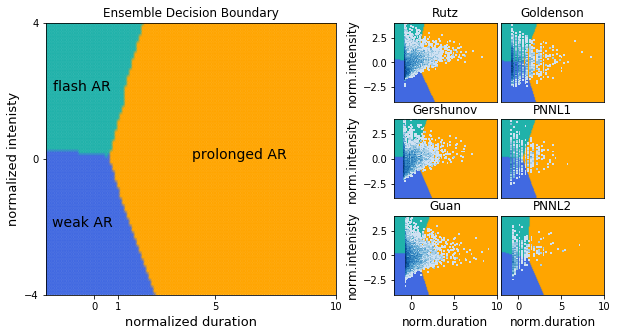

In [15]:
colors = ['royalblue', 'lightseagreen', 'orange', 'fuchsia']
cmap3 = ListedColormap(['royalblue', 'lightseagreen', 'orange'])

fig2 = plt.figure(figsize=(10,5))

ax0 = plt.subplot2grid((34,21), (0,0), rowspan=34, colspan=11)
ax1 = plt.subplot2grid((34,21), (0,13), rowspan=10, colspan=4)
ax2 = plt.subplot2grid((34,21), (12,13), rowspan=10, colspan=4)
ax3 = plt.subplot2grid((34,21), (24,13), rowspan=10, colspan=4)
ax4 = plt.subplot2grid((34,21), (0,17), rowspan=10, colspan=4)
ax5 = plt.subplot2grid((34,21), (12,17), rowspan=10, colspan=4)
ax6 = plt.subplot2grid((34,21), (24,17), rowspan=10, colspan=4)

plot_panel_ens_bound(ax0)
plot_panel_ind_bound(ax1, 0, 'Rutz')
plot_panel_ind_bound(ax2, 1, 'Gershunov')
plot_panel_ind_bound(ax3, 2, 'Guan')
plot_panel_ind_bound(ax4, 3, 'Goldenson')
plot_panel_ind_bound(ax5, 4, 'PNNL1')
plot_panel_ind_bound(ax6, 5, 'PNNL2')

# adjust
ax0.set_xticks(np.array([0, 1, 5, 10]))
ax0.set_yticks(np.array([-4, 0, 4]))
ax1.set_xticks([])
ax2.set_xticks([])
ax4.set_xticks([])
ax5.set_xticks([])
ax4.set_yticks([])
ax5.set_yticks([])
ax6.set_yticks([])
ax3.set_xlabel('norm.duration', size=12)
ax6.set_xlabel('norm.duration', size=12)
ax1.set_ylabel('norm.intensity', size=12)
ax2.set_ylabel('norm.intensity', size=12)
ax3.set_ylabel('norm.intenisty', size=12)

ax0.text(-0.5,-2, 'weak AR', color='black', horizontalalignment='center', size=14)
ax0.text(-0.5,2, 'flash AR', color='black', horizontalalignment='center', size=14)
ax0.text(6,0, 'prolonged AR', color='black', horizontalalignment='center', size=14)

#fig2.savefig(rootdir+'plots/figS8.png', dpi=600)
plt.show()

plt.close()
del(fig2)

### save results to a netcdf file for easy retrieval

In [49]:
def save_ARclassification(method):
    outfile = rootdir+'data/AR_classification/AR_3class.%s.nc' % (method)
    
    outgroup = nc.Dataset(outfile, 'w', format='NETCDF4')
    
    # dimensions
    nedim = outgroup.createDimension('ARevent', None)
    fsdim = outgroup.createDimension('ARfeature_selected', 2)
    
    # dim vars
    nevar = outgroup.createVariable('ARevent', 'i4', ('ARevent'))
    nevar[:] = np.arange(AR_class_index.shape[0])
    fsvar = outgroup.createVariable('ARfeature_selected', 'S2', ('ARfeature_selected'))
    fsvar[0] = 'duration'
    fsvar[1] = 'intensity (land)'
    
    # variables
    ARvar_index = outgroup.createVariable('ARclass_index', 'i4', ('ARevent'))
    ARvar_index.description = '0->weak AR;  1->flash AR;  2->prolonged AR'
    ARvar_index[:] = AR_class_index
    
    ARvar_fnorm = outgroup.createVariable('ARfeature_norm', 'f4', ('ARevent', 'ARfeature_selected'))
    ARvar_fnorm.description = 'normalized using meanstd approach. see '+rootdir+'step3_AR_classification.module.ipynb for details'
    ARvar_fnorm[:] = ARfeature_norm
    ARvar_fnorm.dim1 = 'duration'
    ARvar_fnorm.dim2 = 'intensity (land)'
    
    outgroup.note = 'ARfeature_full taken from '+rootdir+'data/ARTMIP/AR_features/part2/<method>.AR_events_feature.1981-2015.nc'
    outgroup.script = rootdir+'scripts/step3_AR_classification.module.ipynb'
    
    outgroup.close()

In [51]:
for method in ['gershunov','goldenson','guan','rutz','pnnl1','pnnl2','lora','payne','tempest','walton']:
    print(method)
    AR_class_index, ARfeature_full, ARfeature_norm, ARfeature_names, clf = derive_classified_AR(method)

    #save_ARclassification(method)

gershunov
goldenson
guan
rutz
pnnl1
pnnl2
lora
payne
tempest
walton
